# [Visual Static Hand Gesture Recognition Using Convolutional Neural Network](https://www.mdpi.com/1999-4893/16/8/361)

Ссылка кликабельна и ведет на статью

In [1]:
import numpy as np 
import pandas as pd 
import glob
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import keras
from scipy.ndimage import rotate
from sklearn.metrics import accuracy_score
import random

# 1. Look at the Data

In [2]:
DATA_PATH = "/Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/data/croped_images"
RANDOM_STATE = 1228
keras.utils.set_random_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

TEST_DATA_PATH = '/Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/data/croped_test_01_06_cv'
TRAIN_DATA_PATH = '/Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/data/croped_train_01_06_cv'
#VAL_DATA_PATH = '/Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/SOTA_3/data_SOTA_3/temp_val'

# Создадим датафрейм, где будем сохранять путь до картинки и ее лейбл

dactyl = ["А", "Б", "В", "Г", "Е",
          "Ж", "И", "К", "Л", "М",
          "Н", "О", "П", "Р", "С",
          "Т", "У", "Ф", "Х", "Ч",
          "Ш", "Ы", "Э", "Ю", "Я"]

def get_metadata(data_path):
    list_path = []
    list_labels = []
    for label in dactyl:
        label_path = os.path.join(data_path, label, "*")
        image_files = glob.glob(label_path)

        sign_label = [label] * len(image_files)

        list_path.extend(image_files)
        list_labels.extend(sign_label)

    metadata = pd.DataFrame({
        "image_path": list_path,
        "label": list_labels
    })
    return metadata

train_df = get_metadata(TRAIN_DATA_PATH)
print(f"DataFrame for train is ready. Processed {len(train_df)}")
test_df = get_metadata(TEST_DATA_PATH)
print(f"DataFrame for test is ready. Processed {len(test_df)}")
#val_df = get_metadata(VAL_DATA_PATH)
#print(f"DataFrame for val is ready. Processed {len(val_df)}")

DataFrame for train is ready. Processed 0
DataFrame for test is ready. Processed 0


In [3]:
y_train, x_train = train_df['label'], train_df['image_path']
y_test, x_test = test_df['label'], test_df['image_path']

x_train.reset_index(inplace=True, drop=True)
#x_val.reset_index(inplace=True, drop=True)
x_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
#y_val.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

ValueError: zero-size array to reduction operation maximum which has no identity

In [6]:
# будем сжимать изображение

def get_images(data):
    new_data = []
    for image in range(len(data)):
        if data[image].endswith(".jpg") or data[image].endswith(".jpeg") or data[image].endswith(".JPG"):
            numpy_image = cv2.imread(data[image], cv2.COLOR_RGB2BGR)
            image_resized = cv2.resize(numpy_image, (32,32))
            new_data.append(image_resized)
    return new_data

In [7]:
x_train_arr = get_images(x_train)
x_test_arr = get_images(x_test)
#x_val_arr = crop_to_square(x_val)

# Data preproccesing 
## Skin Segmentation & Data Augmentation

In [10]:
def do_preprocess_right(X_data, y_data, augmentation=False):
    num_images = 0
    skin_segmentation_images = []
    labels = []

    for i in range(len(X_data)):
        if i % 100 == 0:
            print(f"Обработано {i} изображений")
        hsv_image = cv2.cvtColor(X_data[i], cv2.COLOR_BGR2HSV)

        # В статье ограничивают только один канал
        lower_skin = np.array([0, 0, 0]) 
        upper_skin = np.array([38, 255, 255]) 

        skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
        skin_extracted_image = cv2.bitwise_and(X_data[i], X_data[i], mask=skin_mask)
        
        if augmentation is True: 
            rotation_degrees = np.random.choice(range(-20, 21), 10, replace=False)
            for angle in rotation_degrees:
                rotated_image = rotate(skin_extracted_image, angle, reshape=False)
                #rotated_image_resized = cv2.resize(rotated_image, (32, 32))
                skin_segmentation_images.append(rotated_image) 
                labels.append(y_data[i])
        else:
            #image_resized = cv2.resize(skin_extracted_image, (32, 32))
            skin_segmentation_images.append(skin_extracted_image)
            labels.append(y_data[i])
        
    return skin_segmentation_images, labels

In [11]:
x_train_prep, y_train_prep = do_preprocess_right(x_train_arr, y_train, augmentation=True)
print("Preproccesing for TRAIN is FINISHED")
x_test_prep, y_test_prep = do_preprocess_right(x_test_arr, y_test,augmentation=False)
print("Preproccesing for TEST is FINISHED")
#x_val_prep, y_val_prep = do_preprocess(x_val_arr, y_val, augmentation=False)
#print("Preproccesing for VALIDATION is FINISHED")


Обработано 0 изображений
Обработано 100 изображений
Обработано 200 изображений
Обработано 300 изображений
Обработано 400 изображений
Обработано 500 изображений
Обработано 600 изображений
Обработано 700 изображений
Обработано 800 изображений
Обработано 900 изображений
Обработано 1000 изображений
Обработано 1100 изображений
Обработано 1200 изображений
Обработано 1300 изображений
Обработано 1400 изображений
Обработано 1500 изображений
Обработано 1600 изображений
Обработано 1700 изображений
Обработано 1800 изображений
Обработано 1900 изображений
Обработано 2000 изображений
Обработано 2100 изображений
Обработано 2200 изображений
Обработано 2300 изображений
Preproccesing for TRAIN is FINISHED
Обработано 0 изображений
Обработано 100 изображений
Обработано 200 изображений
Preproccesing for TEST is FINISHED


In [12]:
# Проверим данные

print(f"Кол-во примеров после препроцессинга в X_data: {len(x_train_prep)}, \
в y_data {len(y_train_prep)}")

print(f"Кол-во примеров после препроцессинга в X_test: {len(x_test_prep)}, \
в y_test {len(y_test_prep)}")

Кол-во примеров после препроцессинга в X_data: 23390, в y_data 23390
Кол-во примеров после препроцессинга в X_test: 259, в y_test 259


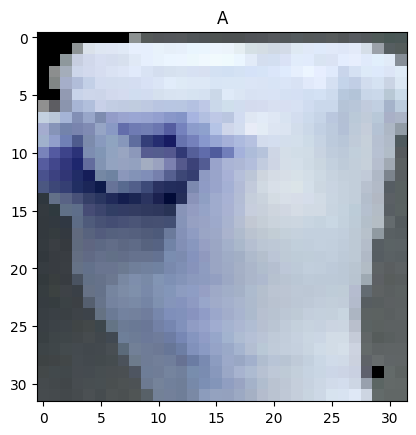

In [14]:
plt.title(y_test_prep[0])
plt.imshow(x_test_prep[0])

In [15]:
shuffled_data = list(zip(y_train_prep, x_train_prep))
random.shuffle(shuffled_data)
y_data_shuffled, x_train_shuffled = zip(*shuffled_data)

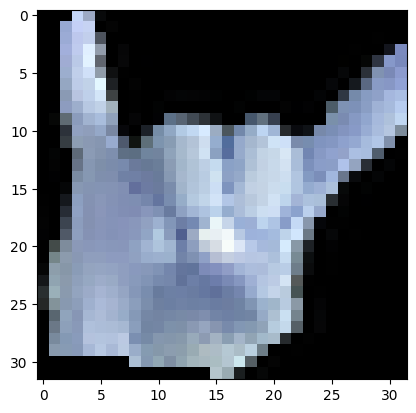

In [17]:
plt.imshow(x_train_shuffled[6])

In [18]:
le = LabelEncoder()
le.fit(y_data_shuffled)
y_train_encoded = le.transform(y_data_shuffled)
y_train_cat = keras.utils.to_categorical(y_train_encoded)

y_test_encoded = le.transform(y_test_prep)
y_test_cat = keras.utils.to_categorical(y_test_encoded)

#y_val_encoded = le.transform(y_val_prep)
#y_val_cat = keras.utils.to_categorical(y_val_encoded)

# Model implementation

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout, Input
from keras.callbacks import ModelCheckpoint


In [20]:
model_1 = Sequential()
model_1.add(Conv2D(15, 4, activation='relu', input_shape=(32,32,3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(30, 1,  activation='relu', padding="same", use_bias=True))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dropout(0.5))
model_1.add(Dense(25, activation='softmax'))  # Adjust the number of units based on the problem (e.g., number of output classes)


model_1.summary()

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 29, 29, 15)     │           735 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 30)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1470)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1470)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │        36,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,990 (148.40 KB)

 Trainable params: 37,990 (148.40 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1)
# Создаем объект ModelCheckpoint для сохранения лучших весов модели
checkpoint = ModelCheckpoint(filepath='/Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/SOTA_1/checkpointHSV.model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True,
                            mode='max',
                            verbose=1)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

x_train_prep = np.array(x_train_shuffled)
#x_val_prep = np.array(x_val_prep)
x_test_prep = np.array(x_test_prep)

In [22]:
history = model_1.fit(
    x=x_train_prep,
    y=y_train_cat, 
    batch_size=64,
    epochs=200,
    verbose=1,
    validation_data=(x_test_prep, y_test_cat),
    validation_batch_size=32,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/200
364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0564 - loss: 17.4995
Epoch 1: val_accuracy improved from -inf to 0.10425, saving model to /Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/SOTA_1/checkpointHSV.model.keras
366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0566 - loss: 17.4053 - val_accuracy: 0.1042 - val_loss: 3.2821
Epoch 2/200
365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1203 - loss: 3.0200
Epoch 2: val_accuracy improved from 0.10425 to 0.13514, saving model to /Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/SOTA_1/checkpointHSV.model.keras
366/366 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.1203 - loss: 3.0199 - val_accuracy: 0.1351 - val_loss: 3.0819
Epoch 3/200
365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1395 - loss: 2.9346
Epoch 3: val_accuracy improved from 0.13514 to 0.16216, saving model to /Users/kamilla/Desktop/masters_diploma/SOTA_MODELS/SOTA_1/checkpointHSV.model.keras
366/366 ━━━━━━━━━━━━━━━━━━━━ 8s 

Epoch 24/200
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4439 - loss: 2.0072
Epoch 24: val_accuracy did not improve from 0.71815
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4440 - loss: 2.0071 - val_accuracy: 0.7027 - val_loss: 1.4844
Epoch 25/200
364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4685 - loss: 1.9062
Epoch 25: val_accuracy did not improve from 0.71815
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4685 - loss: 1.9063 - val_accuracy: 0.6988 - val_loss: 1.3908
Epoch 26/200
365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4644 - loss: 1.9326
Epoch 26: val_accuracy did not improve from 0.71815
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4644 - loss: 1.9327 - val_accuracy: 0.6448 - val_loss: 1.7317
Epoch 27/200
365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4639 - loss: 1.9229
Epoch 27: val_accuracy did not improve from 0.71815
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4639 - loss: 1.9229 - val_

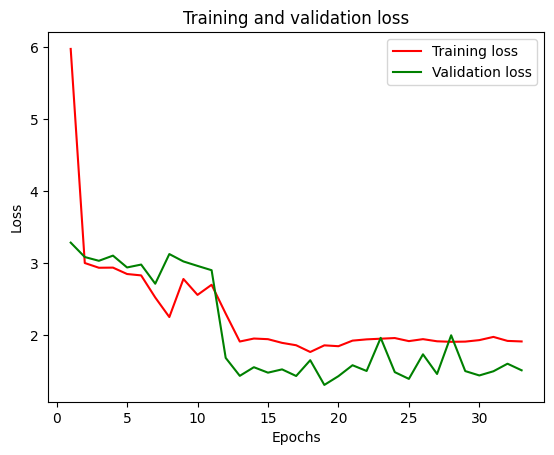

In [23]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 33+1)
#print(len(epochs))
plt.plot(epochs, loss_values, '-', label='Training loss', color='r')
plt.plot(epochs, val_loss_values, '-', label='Validation loss', color='g') 
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
y_pred = model_1.predict(x_test_prep)
#y_pred_val = model.predict(x_val_prep)

y_preds_class_1 = np.argmax(y_pred, axis=1).tolist()
#y_preds_class_val = np.argmax(y_pred_val, axis=1).tolist()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [25]:
accuracy_test = accuracy_score(y_test_encoded, y_preds_class_1)
print(f"Точность на тесте (без аугументации): {accuracy_test}")

#accuracy_val = accuracy_score(y_val_encoded, y_preds_class_val)
#print(f"Точность на валидации: {accuracy_val}")

Точность на тесте (без аугументации): 0.667953667953668


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_encoded, y_preds_class_1, average='weighted')
recall = recall_score(y_test_encoded, y_preds_class_1, average='weighted')
f1 = f1_score(y_test_encoded, y_preds_class_1, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print(classification_report(y_test_encoded, y_preds_class_1)) 

Precision: 0.6819979516408089
Recall: 0.667953667953668
F1-score: 0.6574986237353421
